# FIR Delay Effect


## Importing Libraries


In [310]:
##Scipy functions
import scipy.io.wavfile as wv
from IPython.display import Audio
from scipy.signal import welch
from scipy.optimize import curve_fit

##Others
import numpy as np
import os
import matplotlib.pyplot as plt

# Main


## Import .wav file as signal


In [311]:
DATA_FOLDER_PATH = "../Data" #Specify Data folder directory here
FILENAME = "noise2.wav" #Specify file name here


filepath = os.path.join(DATA_FOLDER_PATH, FILENAME)

In [312]:
sampleFreq, audio = wv.read(filepath) #reading audio signal here

In [313]:
sampleLen = len(audio)/sampleFreq
print(f"Sound is {sampleLen}s long")

Sound is 8.7500625s long


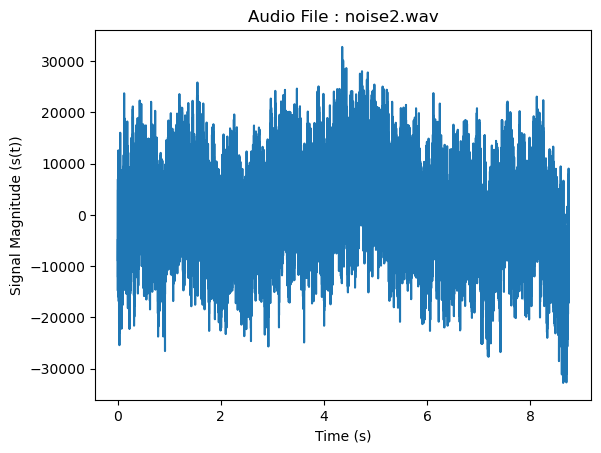

In [314]:
timeX = np.arange(0, sampleLen, 1/sampleFreq)

plt.plot(timeX, audio)
plt.xlabel("Time (s)")
plt.ylabel("Signal Magnitude (s(t))")
plt.title(f"Audio File : {FILENAME}")

plt.show()

In [315]:
Audio(audio, rate=sampleFreq)

## Spectrum Density


### Periodogram


In [316]:
## Compute the fft of noise signal

fftSignal = np.fft.fft(audio)

powerSpectralDensity = (1/len(audio)) * np.abs(fftSignal) ** 2 

In [317]:
freqX = np.fft.fftfreq(len(audio), 1/sampleFreq)[:len(audio) // 2]
powerSpectralDensity = powerSpectralDensity[:len(audio) // 2]

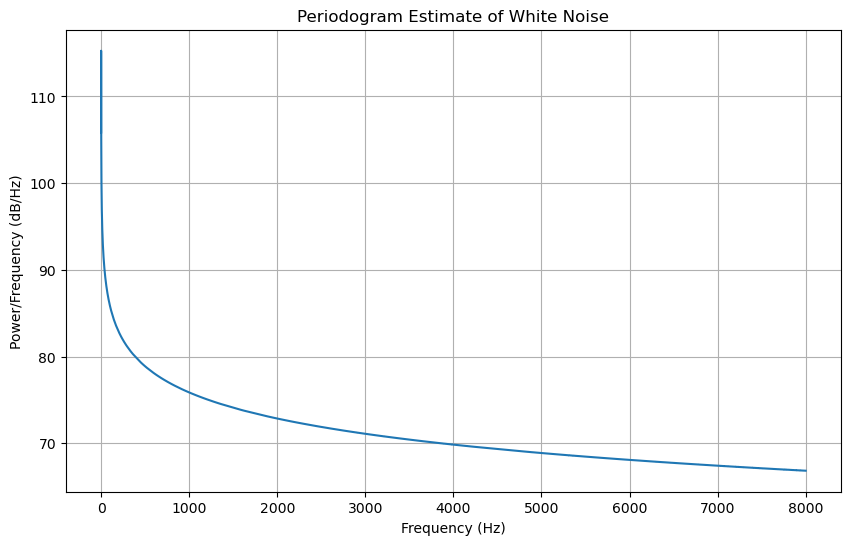

In [318]:
plt.figure(figsize=(10, 6))
plt.plot(freqX, 10 * np.log10(powerSpectralDensity))
plt.title("Periodogram Estimate of White Noise")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power/Frequency (dB/Hz)")
plt.grid(True)
plt.show()

### Welch


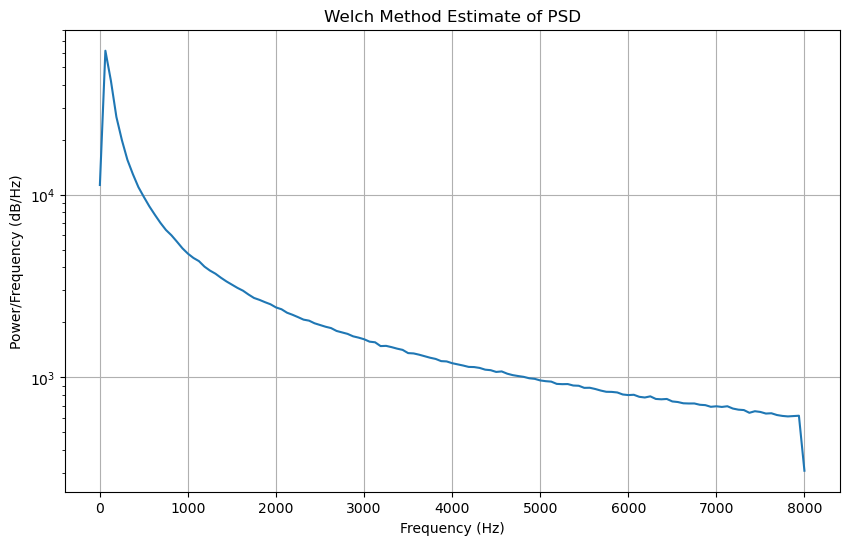

In [319]:
# Use the Welch method to estimate the PSD
freqX, psdEstimate = welch(audio, fs=sampleFreq)

# Plot the PSD estimate
plt.figure(figsize=(10, 6))
plt.semilogy(freqX, psdEstimate)
plt.title("Welch Method Estimate of PSD")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power/Frequency (dB/Hz)")
plt.grid(True)
plt.show()


### Noise Color Estimating


In [320]:
#Using fit_curve function of scipy to determine speed of function

def functionAllure(freq, exponent, a):
    return a * freq**(-exponent)

popt, _ = curve_fit(functionAllure, freqX[1:], psdEstimate[1:], bounds = ([-2, 0], [3, np.inf]))

/tmp/ipykernel_6332/58697202.py:4: RuntimeWarning: divide by zero encountered in power
  return a * freq**(-exponent)


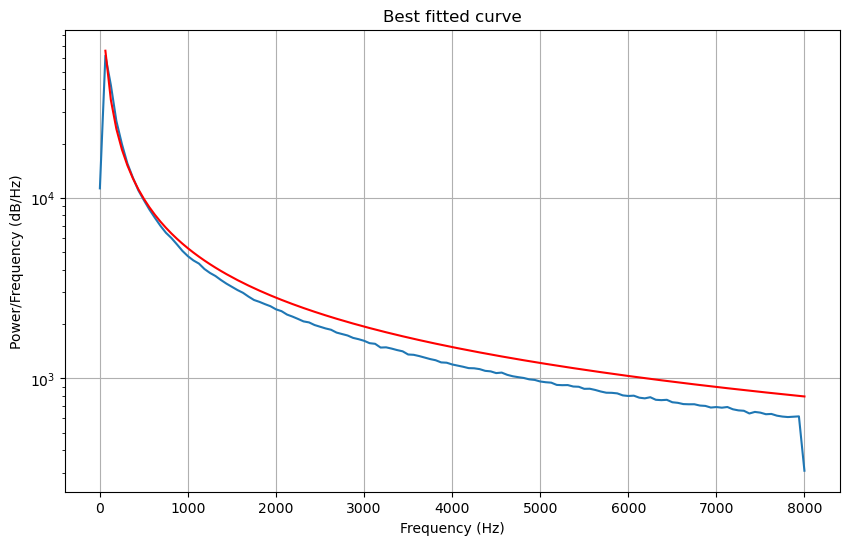

In [321]:
## Display PSD Estimator and the best fitted curve


plt.figure(figsize=(10, 6))
plt.semilogy(freqX, psdEstimate, label='PSD Estimator')
plt.semilogy(freqX, functionAllure(freqX, *popt), color='red', label='Best fitted curve')
plt.title("Best fitted curve")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power/Frequency (dB/Hz)")
plt.grid(True)
plt.show()

In [322]:
NOISE_COLOR_DICT = {'White Noise':0,
                    'Pink Noise':1,
                    'Brown Noise':2,
                    'Blue Noise':-1}

In [323]:
## Find the closest value in the dictionnary to determine the color of the noise

noiseColor, _ = min(NOISE_COLOR_DICT.items(), key=lambda dictItem: abs(dictItem[1]-popt[0]))

In [324]:
popt[0]

0.9098304051357232

In [325]:
print(f"Noise is a {noiseColor}.")

Noise is a Pink Noise.


In [326]:
## Truc bizarre sur Noise3 - détecté comme blanc mais a une allure de rose

## Wiener Filter


### Load Audio Data


In [327]:
DATA_FOLDER_PATH = "../Data" #Specify Data folder directory here
FILENAME = "music.wav" #Specify file name here


filepath = os.path.join(DATA_FOLDER_PATH, FILENAME)

In [328]:
sampleFreq, audio = wv.read(filepath) #reading audio signal here

In [329]:
sampleLen = len(audio)/sampleFreq
print(f"Sound is {sampleLen}s long")

Sound is 8.7500625s long


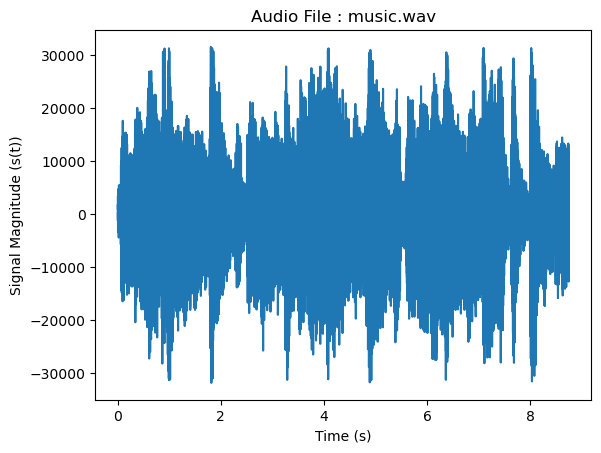

In [330]:
timeX = np.arange(0, sampleLen, 1/sampleFreq)

plt.plot(timeX, audio)
plt.xlabel("Time (s)")
plt.ylabel("Signal Magnitude (s(t))")
plt.title(f"Audio File : {FILENAME}")

plt.show()

In [331]:
Audio(audio, rate=sampleFreq)

In [332]:
#Uncomment this cell to test the filter with a Sine Signal of frequency (440Hz)

duration = 1
freq = 440

timeX = np.linspace(0, duration, sampleFreq * duration, endpoint=False)

audio = np.sin(2 * np.pi * freq * timeX)

### Generate noisy signal


To achieve a SNR of $y \in \{0dB; 5dB; 10dB; 15dB; 20 dB \}$, we need to generate a noisy signal with the desired magnitude.


In [333]:
audioMagnitude = np.mean(audio ** 2)

For a Gaussian white noise, the power of the signal is just the variance of the gaussian function.µ


In [334]:
SNR_LIST = [0, 5, 10, 15, 20] ##List of various SNR level

noiseVarianceList = [audioMagnitude/(10**(SNR/20)) for SNR in SNR_LIST]

In [335]:
noiseSignalList = [np.random.normal(0, np.sqrt(noiseVariance), audio.shape) for noiseVariance in noiseVarianceList] ## Creatin the list of all noisy signal

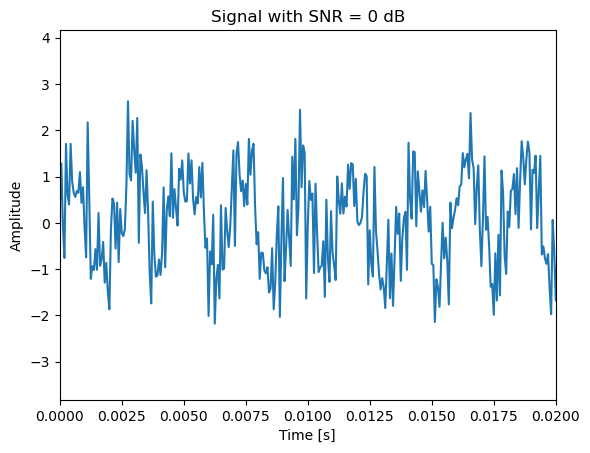

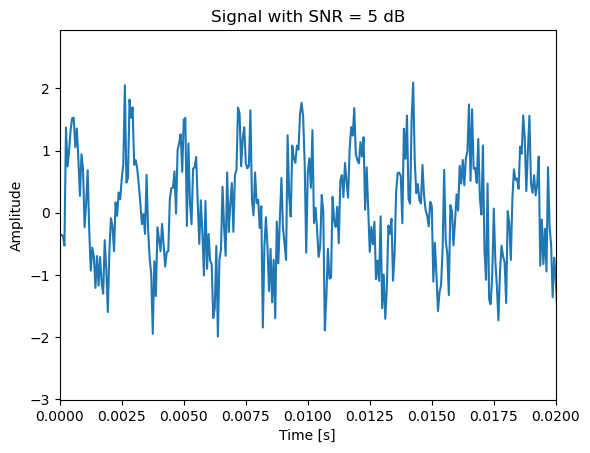

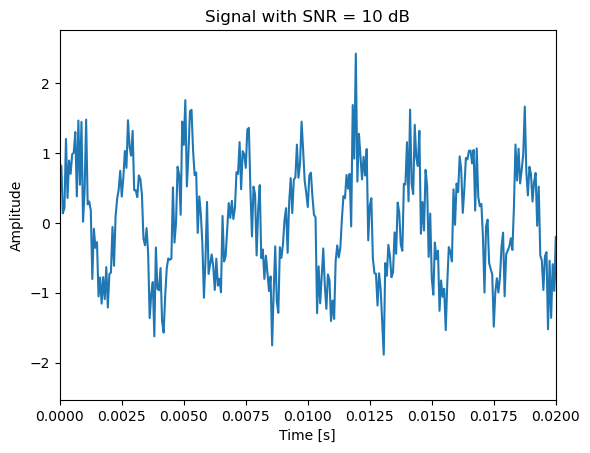

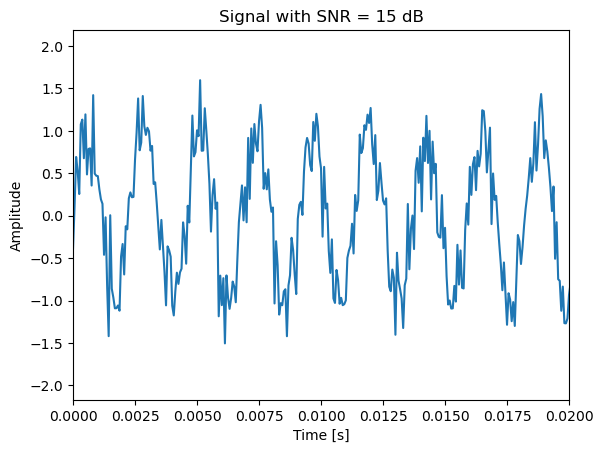

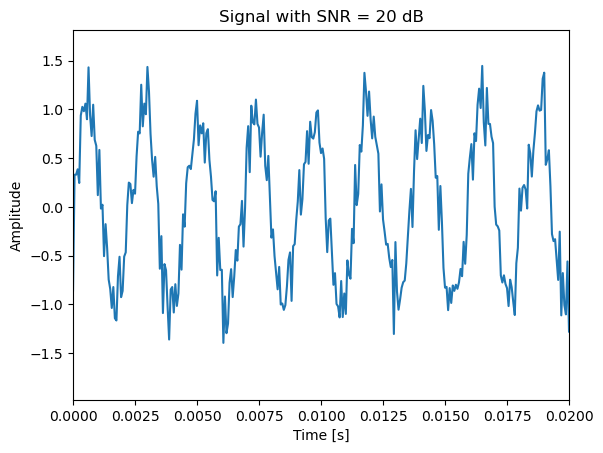

In [336]:
##Displaying all noisy signal

for i, noiseSignal in enumerate(noiseSignalList):
    plt.plot(timeX, audio + noiseSignal)
    plt.title(f'Signal with SNR = {SNR_LIST[i]} dB')
    plt.xlabel('Time [s]')
    plt.ylabel('Amplitude')
    plt.xlim(0, 0.02) #For clarity reason, plot only the first 0.02s of the signal
    plt.show()

### Compute the Wiener filter


Since both the input and noise signal are known, we can compute the Wiener filter :


In [337]:
_, signalPSD = welch(audio, sampleFreq)

WienerFilterList = []

for noiseSignal in noiseSignalList: 
    f, noisePSD = welch(noiseSignal, sampleFreq)
    WienerFilterList.append((f, signalPSD/(signalPSD + noisePSD)))


In [338]:
fftSignalList = [np.fft.fft(audio + noiseSignal) for noiseSignal in noiseSignalList] # Calculate fft of all noisy signals

In [339]:
freqX = np.fft.fftfreq(len(audio), 1/sampleFreq)

In [340]:
fullWienerFilterList = []

for (xWiener, WienerFilter) in WienerFilterList:
    fullWienerFilterList.append(np.interp(freqX, xWiener, WienerFilter)) ##Interpolate the Wiener filter to have the same length as the fft

In [341]:
filteredSignalFFTList = [fftSignalList[i] * fullWienerFilterList[i] for i in range(len(fftSignalList))] ## Apply Wiener filter on each noisy signal in the frequency domain

In [342]:
filteredSignalList = [np.real(np.fft.ifft(filteredSignalFFT)) for filteredSignalFFT in filteredSignalFFTList] ## Calculate the Inverse Fourier Transform of the signal

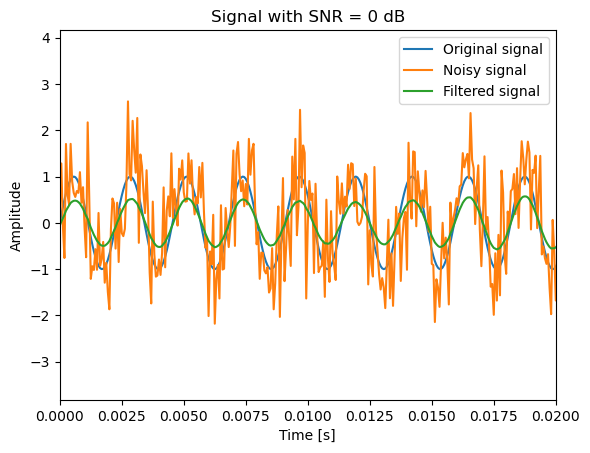

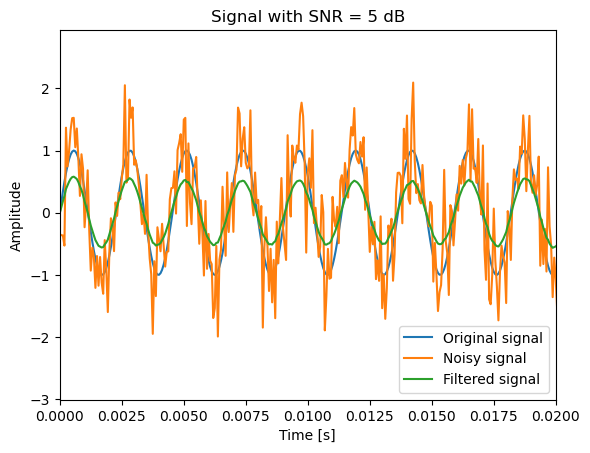

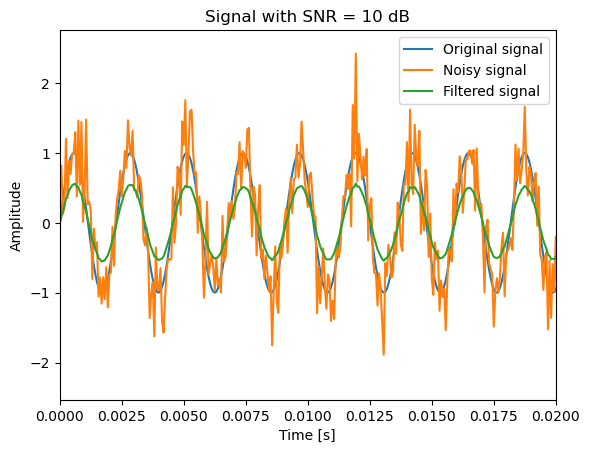

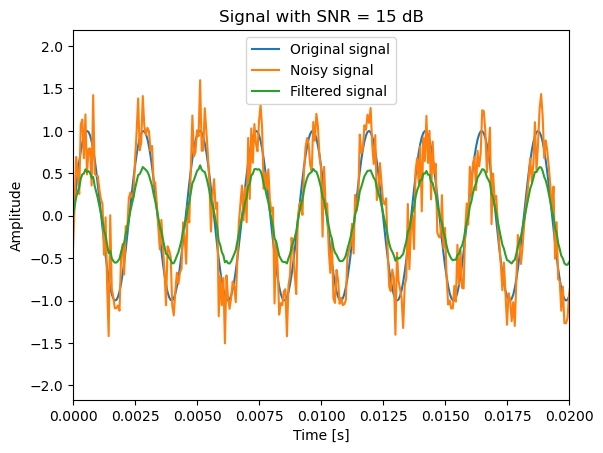

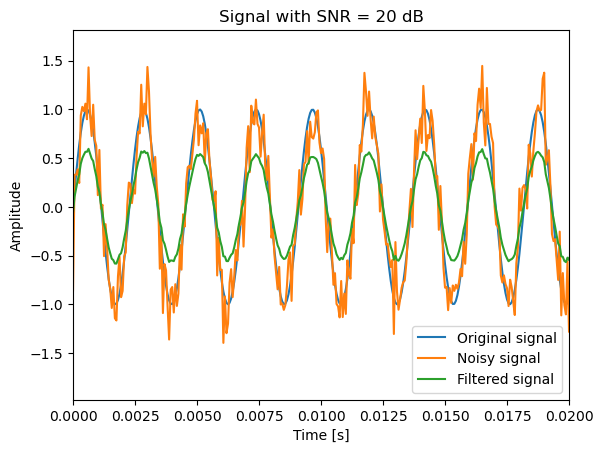

In [343]:
##Displaying all filtered signal

for i, noiseSignal in enumerate(noiseSignalList):
    plt.plot(timeX, audio, label = 'Original signal')
    plt.plot(timeX, audio + noiseSignal, label = 'Noisy signal')
    plt.plot(timeX, filteredSignalList[i], label = 'Filtered signal')
    plt.title(f'Signal with SNR = {SNR_LIST[i]} dB')
    plt.xlabel('Time [s]')
    plt.ylabel('Amplitude')
    plt.xlim(0, .02) #For clarity reason, plot only the first 0.02s of the signal
    plt.legend()
    plt.show()